# Dataset Class (PyTorch Dataset)

Used for data loading

In [1]:
from torch.utils.data import Dataset
import os
import torch
import numpy as np
from scipy import interpolate
from scipy.fft import fft, ifft

class PingData(Dataset):
    def __init__(self, path):
        self.length = 0
        self.source_files = []
        self.label_files = []
        self.s_data = []
        s_data_lengths = []
        self.echo_length = 512  #长度512
        self.label_length = 512 #长度512
        for d, s, f in os.walk(os.path.join(path, 'source')):
            for file in f:
                self.source_files.append(os.path.join(d, file))

        # source data
        for file in self.source_files:
            fh = open(file)
            text = fh.read()
            lines = text.strip().split('\n')
            seq = [float(num.strip()) for num in lines]
            s_data_lengths.append(len(seq))
            x = np.arange(len(seq))
            tck = interpolate.splrep(x, seq, s=0)
            xn = np.arange(x[0], x[-1], (x[-1] - x[0]) / self.echo_length)
            yn = interpolate.splev(xn, tck, der=0)
            if len(yn) > self.echo_length:
                yn = yn[0:self.echo_length]
            yn = (yn - min(yn)) / (max(yn) - min(yn))
            self.s_data.append(yn)

        # label data
        self.l_data = []
        for d, s, f in os.walk(os.path.join(path, 'label')):
            for file in f:
                self.label_files.append(os.path.join(d, file))
        fid = 0
        for file in self.label_files:
            fh = open(file)
            text = fh.read()
            seq = round(float(text.strip()) / s_data_lengths[fid] * 512)
            yn = np.zeros((512, 1))
            yn[seq] = 1
            self.l_data.append(yn)
            fid = fid + 1

        self.length = len(self.s_data)

    def __getitem__(self, index):
        echo_data = torch.tensor(self.s_data[index])
        label_data = torch.tensor(self.l_data[index])
        echo_data = echo_data.reshape([1, echo_data.shape[0]])
        label_data = label_data.squeeze(1).unsqueeze(0)
        return echo_data, label_data

    def __len__(self):
        return self.length


# Use FFT to filter the data
class PingDataFFT(Dataset):
    def __init__(self, path):
        self.length = 0
        self.source_files = []
        self.label_files = []
        self.s_data = []
        s_data_lengths = []
        self.echo_length = 512  #长度512
        self.label_length = 512 #长度512
        for d, s, f in os.walk(os.path.join(path, 'source')):
            for file in f:
                self.source_files.append(os.path.join(d, file))

        # source data
        for file in self.source_files:
            fh = open(file)
            text = fh.read()
            lines = text.strip().split('\n')
            seq = [float(num.strip()) for num in lines]
            s_data_lengths.append(len(seq))
            yn = resize_sample(seq, self.echo_length)
            self.s_data.append(yn)

        # label data
        self.l_data = []
        for d, s, f in os.walk(os.path.join(path, 'label')):
            for file in f:
                self.label_files.append(os.path.join(d, file))
        fid = 0
        for file in self.label_files:
            fh = open(file)
            text = fh.read()
            seq = round(float(text.strip()) / s_data_lengths[fid] * 512)
            yn = np.zeros(512)
            yn[seq] = 1
            self.l_data.append(yn)
            fid = fid + 1

        self.length = len(self.s_data)

    def __getitem__(self, index):
        echo_data = torch.tensor(self.s_data[index])
        label_data = torch.tensor(self.l_data[index])
        echo_data = echo_data.reshape([1, echo_data.shape[0]])
        label_data = label_data.unsqueeze(0)
        return echo_data, label_data

    def __len__(self):
        return self.length


def resize_sample(seq, echo_length, use_fft = True, w = 40):
    x = np.arange(len(seq))
    tck = interpolate.splrep(x, seq, s=0)
    xn = np.arange(x[0], x[-1], (x[-1] - x[0]) / echo_length)
    yn = interpolate.splev(xn, tck, der=0)

    l = int(w / 2) # default 20
    if use_fft:
        yf = fft(yn)
        yf[l:-l] = 0
        yn = ifft(yf)

    if len(yn) > echo_length:
        yn = yn[0:echo_length]
    yn = (yn - min(yn)) / (max(yn) - min(yn))

    return yn

# Model Structure 

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class TransformerModel(nn.Module):

    def __init__(self):
        super(TransformerModel, self).__init__()

        embed_dim = 1
        in_dim = 1
        out_dim = 1

        self.positional_encoding = PositionalEncoding(embed_dim)

        self.encoder_embedding = torch.nn.Linear(
            in_features=in_dim, out_features=embed_dim
        )
        self.decoder_embedding = torch.nn.Linear(
            in_features=out_dim, out_features=embed_dim
        )

        self.ninp = 1
        self.encoder_embedding = nn.Linear(512, 32)
        self.decoder_embedding = nn.Linear(32, 512)

        self.transformer_layers = nn.Transformer(nhead=4, num_encoder_layers=4, d_model=512)

        encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)

    def forward(self, src):
        # src = self.positional_encoding(src)
        # src = self.encoder_embedding(src)
        # tgt = self.positional_encoding(tgt)
        # tgt = self.encoder_embedding(tgt)

        output = self.transformer_encoder(src)

        # softmax 
        output = F.softmax(output, dim=2)

        return output


def model_precision(det_bottom_ids, pre_bottom_ids):
    nc = 0
    for i in range(len(pre_bottom_ids)):
        if abs(pre_bottom_ids[i] - det_bottom_ids[i]) <= 0.02 * det_bottom_ids[i]:
            nc = nc + 1
    return nc / len(pre_bottom_ids) * 100

# Training the model

1448


D:\ProgramData\Anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\YAN\AppData\Local\Temp\ipykernel_15168\1292325262.py:54: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:308.)
  inputs = inputs.type(torch.cuda.FloatTensor)


Epoch: 0, Training Loss: 1.927e-03, Training Correctness 0.523	Validation Loss: 1.914e-03 Validation Correctness 0.528
Epoch: 1, Training Loss: 1.910e-03, Training Correctness 0.583	Validation Loss: 1.908e-03 Validation Correctness 0.636
Epoch: 2, Training Loss: 1.900e-03, Training Correctness 0.642	Validation Loss: 1.901e-03 Validation Correctness 0.627
Epoch: 3, Training Loss: 1.889e-03, Training Correctness 0.717	Validation Loss: 1.899e-03 Validation Correctness 0.712
Epoch: 4, Training Loss: 1.887e-03, Training Correctness 0.722	Validation Loss: 1.893e-03 Validation Correctness 0.783
Epoch: 5, Training Loss: 1.881e-03, Training Correctness 0.722	Validation Loss: 1.887e-03 Validation Correctness 0.770
Epoch: 6, Training Loss: 1.875e-03, Training Correctness 0.727	Validation Loss: 1.895e-03 Validation Correctness 0.767
Epoch: 7, Training Loss: 1.874e-03, Training Correctness 0.758	Validation Loss: 1.887e-03 Validation Correctness 0.827
Epoch: 8, Training Loss: 1.870e-03, Training Cor

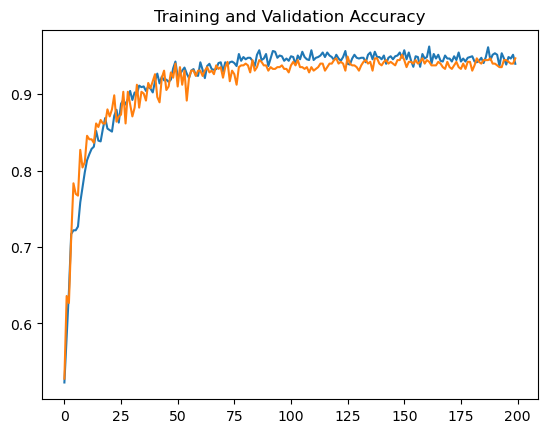

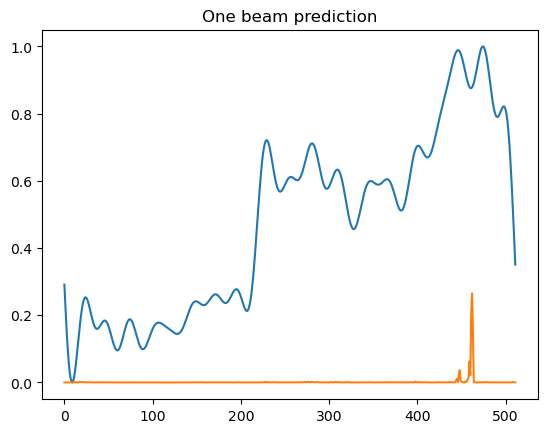

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import random_split
import matplotlib.pyplot as plt


batchsize = 16  # can be changed

train_path = 'D:/MBESSample60_'

# sample_set = PingData(train_path)
sample_set = PingDataFFT(train_path)
print(len(sample_set))
train_sample_num = round(.7 * len(sample_set))
valid_sample_num = round(.3 * len(sample_set))

train_set, valid_set = random_split(sample_set, [train_sample_num, valid_sample_num])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batchsize, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batchsize, shuffle=True)

device = "cuda"  # "cpu"

model_1d = TransformerModel()
model_1d.to(device)

optimizer = torch.optim.RMSprop(model_1d.parameters(), lr=0.00001)
model = model_1d
loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.CrossEntropyLoss()
tr_loader = train_loader
val_loader = valid_loader

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
epochs = 200
allow_error = 0.025  # 2.5%

last_input = []
last_output = []

for epoch in range(epochs):
    training_loss = 0.0
    valid_loss = 0.0
    model.train()
    n_training = 0
    n_training_corret = 0
    for batch in tr_loader:
        optimizer.zero_grad()
        inputs, targets = batch
        inputs = inputs.type(torch.cuda.FloatTensor)
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets = targets.type(torch.cuda.FloatTensor)

        # output = model(inputs, inputs)
        output = model(inputs)

        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        n_training += inputs.size(0)
        training_loss += loss.data.item() * inputs.size(0)
        predict_results = torch.max(output, dim=2)[1].cpu().numpy()
        target_results = torch.max(targets, dim=2)[1].cpu().numpy()
        for i in range(inputs.size(0)):
            if abs(predict_results[i] - target_results[i]) < allow_error * target_results[i]:
                n_training_corret += 1
    training_loss /= len(tr_loader.dataset)
    training_correcness = n_training_corret / len(tr_loader.dataset)

    model.eval()
    num_correct = 0
    num_examples = 0
    for batch in val_loader:
        inputs, targets = batch
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)  # loss function:? int64
        # output = model(inputs, inputs)
        output = model(inputs)
        loss = loss_fn(output, targets)
        valid_loss += loss.data.item() * inputs.size(0)
        predict_results = torch.max(output, dim=2)[1].cpu().numpy()
        target_results = torch.max(targets, dim=2)[1].cpu().numpy()
        for i in range(inputs.size(0)):
            if abs(predict_results[i] - target_results[i]) < allow_error * target_results[i]:
                num_correct += 1
        last_input = inputs[0,:,:]
        last_output = output[0,:,:]
    valid_loss /= len(val_loader.dataset)
    valid_correct = num_correct / len(val_loader.dataset)
    print(f'Epoch: {epoch}, Training Loss: {training_loss:.3e}, Training Correctness {training_correcness:.3f}'
          f'\tValidation Loss: {valid_loss:.3e} Validation Correctness {valid_correct:.3f}')

    train_losses.append(training_loss)
    val_losses.append(valid_loss)
    train_accuracy.append(training_correcness)
    val_accuracy.append(valid_correct)

    if training_correcness > 0.95:
        optimizer = torch.optim.RMSprop(model_1d.parameters(), lr=0.000001)


torch.save(model_1d, f".attention_1d_mbes_{epochs}.h5")

plt.figure()
plt.title('Training and Validation Accuracy')
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.show()

plt.figure()
plt.title('One beam prediction')
plt.plot(last_input.squeeze(0).cpu().detach().numpy())
plt.plot(last_output.squeeze(0).cpu().detach().numpy())
plt.show()

# Testing the model

E:\Qsync\Python\1D-Transformer-MBES\tools.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1d = torch.load(model_file, map_location=torch.device(f'{device}'))


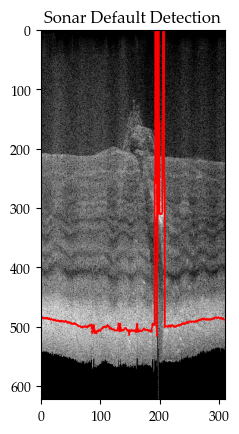

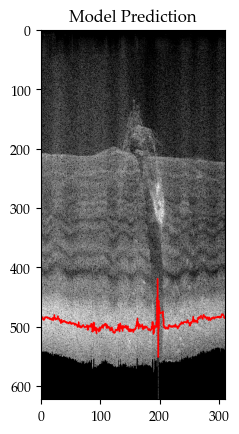

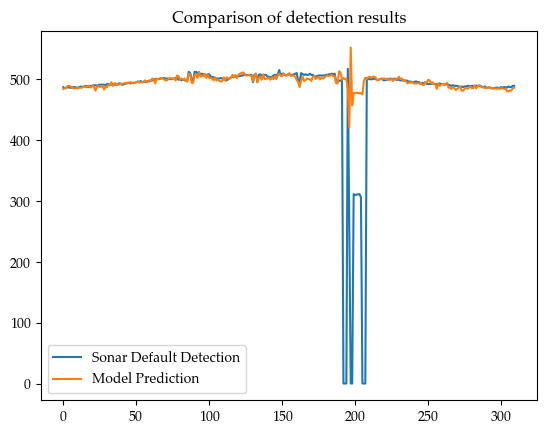

In [4]:
from EMAllParser import *
import torch
from WCP import gen_ac_wc, wc_alongtrack_image
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from tools import along_track_run, across_track_run

em_file = r'E:\Data\Shipwreck\0007_20060331_235313_ShipName.all'
em_parser = EMAllParser(em_file)

incidentAngel = 60
model_file = "attention_1d_mbes_best.h5"

det_bottom_ids, pre_bottom_ids = along_track_run(em_file, incidentAngel, model_file)
plt.figure()
plt.title('Sonar Default Detection')
img = wc_alongtrack_image(em_parser, incidentAngel, showSeabed=True, newDrs=det_bottom_ids)
plt.imshow(img)
plt.figure()
plt.title('Model Prediction')
img = wc_alongtrack_image(em_parser, incidentAngel, showSeabed=True, newDrs=pre_bottom_ids)
plt.imshow(img)
plt.show()
plt.figure()
plt.title('Comparison of detection results')
plt.plot(det_bottom_ids, label='Sonar Default Detection')
plt.plot(pre_bottom_ids, label='Model Prediction')
plt.legend()
plt.show()

Datagram 		 Type 						Number 
73		: EM_Install_Parameters_Start     1
82		: EM_Runtime_Parameters           3
85		: EM_Sound_Speed_Profile_Datagram 1
105		: EM_Install_Parameters_Stop      1
107		: EM_Water_Column_Datagram        6676



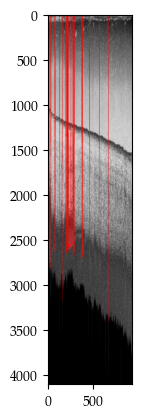

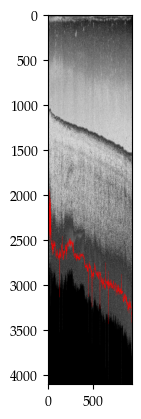

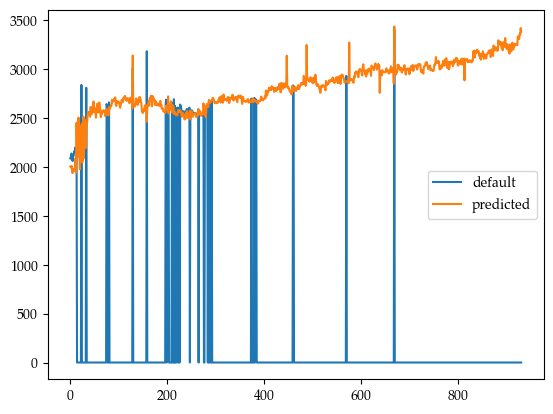

In [5]:
from EMAllParser import *
import matplotlib.pyplot as plt
from tools import along_track_run, across_track_run
from WCP import  wc_alongtrack_image

em_file = r'E:\Data\EM710.wcd'

em_parser = EMAllParser(em_file)
print(em_parser)

incidentAngel = 60

model_file = "attention_1d_mbes_best.h5"

det_bottom_ids, pre_bottom_ids = along_track_run(em_file, incidentAngel, model_file, True, 10)
plt.figure()
img = wc_alongtrack_image(em_parser, incidentAngel, showSeabed=True, newDrs=det_bottom_ids)
plt.imshow(img)
plt.figure()
img = wc_alongtrack_image(em_parser, incidentAngel, showSeabed=True, newDrs=pre_bottom_ids)
plt.imshow(img)
plt.show()
plt.figure()
plt.plot(det_bottom_ids, label = 'default')
plt.plot(pre_bottom_ids, label = 'predicted')
plt.legend()
plt.show()

Datagram 		 Type 						Number 
65		: EM_Attitude_Datagram            786
72		: EM_Heading_Datagram             721
73		: EM_Install_Parameters_Start     1
80		: EM_Position_Datagrams           1590
82		: EM_Runtime_Parameters           197
85		: EM_Sound_Speed_Profile_Datagram 1
105		: EM_Install_Parameters_Stop      1
107		: EM_Water_Column_Datagram        1152



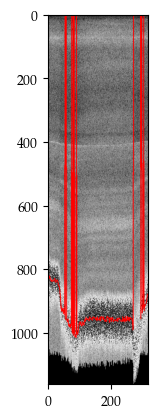

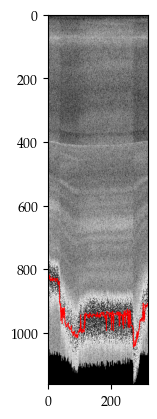

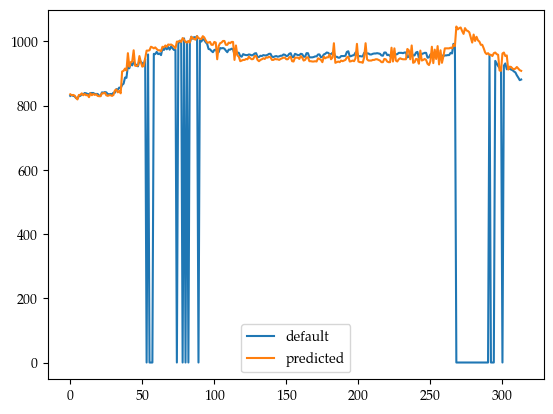

In [6]:
from EMAllParser import *
import matplotlib.pyplot as plt
from tools import along_track_run, across_track_run
from WCP import  wc_alongtrack_image

em_file = r'T:\MultibeamWaterColumn\EX1402L2\0055_20140322_070207_EX1402L2_MB.wcd'

em_parser = EMAllParser(em_file)
print(em_parser)

incidentAngel = 65

model_file = "attention_1d_mbes_best.h5"

det_bottom_ids, pre_bottom_ids = along_track_run(em_file, incidentAngel, model_file, True, 20)
plt.figure()
img = wc_alongtrack_image(em_parser, incidentAngel, showSeabed=True, newDrs=det_bottom_ids)
plt.imshow(img)
plt.figure()
img = wc_alongtrack_image(em_parser, incidentAngel, showSeabed=True, newDrs=pre_bottom_ids)
plt.imshow(img)
plt.show()
plt.figure()
plt.plot(det_bottom_ids, label = 'default')
plt.plot(pre_bottom_ids, label = 'predicted')
plt.legend()
plt.show()